# Canonical form of MPS
Matrix product states can be decomposed into canonical form. The procedure is outlined in arxiv arxiv:1008.3477 Eq. 161. The canonical form has the following MPS diagram

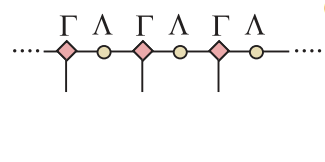

For sake of concreteness, we provide a simple implementation here to illustrate the algorithm

**TTD Canonical**
Let $A_{i_0,i_1,\cdots, i_{n-1}}$ be of shape $(d_0, d_1, \cdots, d_{n-1})$

1. $T^{[0]} = A_{i_0,i_1,\cdots, i_{n-1}}$ and $r_0 = 1$, $i=0$
2. Reshape $T^{[i]}$ into shape $(r_i d_{i}, \cdots)$ where $\cdots$ denote whatever shape that is left over
3. Perform SVD and get $U_i, \Sigma_i, V_i^\dagger$ of shape $(r_i d_i, r_{i+1}), (r_{i+1},r_{i+1})$ and $(r_{i+1},\cdots)$
4. Reshape $U_i$ to be $(r_i, d_i, r_{i+1})$ 
5. If $i>0$, contract $U_i$ with $\left(\Sigma_{i-1}\right)^{-1}$, which has shape $(r_i,r_i)$ along the first virtual index 
6. Store $U_i$ and $\Sigma_i$ as the $i$-th canonical block
7. Let $T^{[i+1]} = \Sigma_i V_i^\dagger$ which has shape $(r_{i+1}, d_{i+1}\cdots)$ and repeat from 2 for $i=0$ to $i=n-2$
8. Contract the last $U$ matrix with the inverse of the last Schmidt's matrix along the first virtual index to restore proper normalization
9. The algorithm will produce $n$ $U$ matrix and $n-1$ Schmidt matrix

In [18]:
import numpy as np
from numpy.linalg import svd

def eps_rank(vec,eps): 
    # Input: 
    # vec: Positive vector of size n with a[i]>=a[j] for all i>j
    # eps: Positive real number specifying precision
    # Return: The rank of the vector, treating everything < epsilon as 0
    return np.sum(vec>eps)

In [43]:
def tt_svd_canonical(tensor,eps=1e-6):
    # Input: Tensor of shape (n1,n2,...,nd) with dimension d for each index
    # Ouput: List containing d tensor train and bond dimensions r1-rd, each of them of dimension (nk,rk-1,rk)
    r = [1] # r0 = 1
    T = tensor
    n = tensor.shape
    basis_train = [] # Train of basis transformation
    schmidt_train = [] # Train of Schmidt values 
    d = len(tensor.shape)
    for k in range(0,d-1):
        T = np.reshape(T,(r[k]*n[k],-1))
        print('T shape:', T.shape)
        U,S,Vh = svd(T,full_matrices=False) # Perform SVD

        # Rank dropping
        rkp1 = eps_rank(S,eps)
        S = S[:rkp1]
        U = U[:,:rkp1]
        Vh = Vh[:rkp1,:]

        print('U, S, VT shape:', U.shape, S.shape, Vh.shape)
        Uk = np.reshape(U,(r[k],n[k],rkp1))
        if k > 0:
            Skm1 = schmidt_train[-1]
            Uk = np.tensordot(np.diag(1/Skm1),Uk,(1,0))
        basis_train.append(Uk)
        schmidt_train.append(S)
        r.append(rkp1)
        
        T = np.tensordot(np.diag(S),Vh,(1,0))
        print('C new shape: ',T.shape)
    T = T.reshape((r[d-1],n[d-1],1))
    Skm1 = schmidt_train[-1]
    T = np.tensordot(np.diag(1/Skm1),T,(1,0))
    basis_train.append(T)
    return basis_train, schmidt_train

In [44]:
A = np.zeros(shape=(2,2,2,2,2,2)) # 6 qubit
A[0,1,0,1,0,1] = 1
A[0,1,0,1,1,0] = -1
A[0,1,1,0,0,1] = -1
A[0,1,1,0,1,0] = 1
A[1,0,0,1,0,1] = -1
A[1,0,0,1,1,0] = 1
A[1,0,1,0,0,1] = 1
A[1,0,1,0,1,0] = -1
A /= np.sqrt(2)**3

In [45]:
GammaMat, SigmaMat = tt_svd_canonical(A)

T shape: (2, 32)
U, S, VT shape: (2, 2) (2,) (2, 32)
C new shape:  (2, 32)
T shape: (4, 16)
U, S, VT shape: (4, 1) (1,) (1, 16)
C new shape:  (1, 16)
T shape: (2, 8)
U, S, VT shape: (2, 2) (2,) (2, 8)
C new shape:  (2, 8)
T shape: (4, 4)
U, S, VT shape: (4, 1) (1,) (1, 4)
C new shape:  (1, 4)
T shape: (2, 2)
U, S, VT shape: (2, 2) (2,) (2, 2)
C new shape:  (2, 2)


## Entanglement entropies 
Observe that entanglement entropies is as expected

In [46]:
SigmaMat # Observe the alternating entanglement entropies

[array([0.70710678, 0.70710678]),
 array([1.]),
 array([0.70710678, 0.70710678]),
 array([1.]),
 array([0.70710678, 0.70710678])]

## Normalization of the right and left basis matrix 
The basis matrix takes the following form:

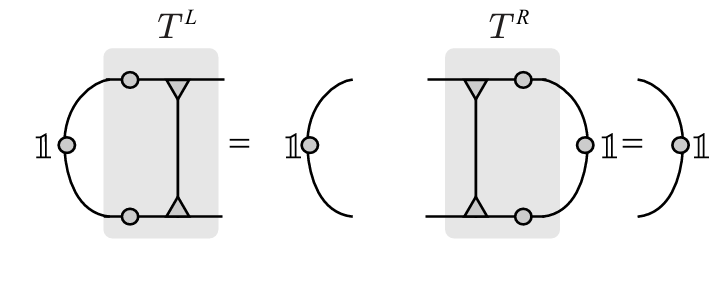

This can be explicitly checked in our example here:

In [47]:
np.tensordot(GammaMat[-1],GammaMat[-1],((1,2),(1,2)))

array([[1., 0.],
       [0., 1.]])

In [48]:
GammaMat[-1]

array([[[ 0.],
        [ 1.]],

       [[-1.],
        [ 0.]]])

In [49]:
np.tensordot(GammaMat[0],GammaMat[0],((0,1),(0,1)))

array([[1., 0.],
       [0., 1.]])

In [50]:
np.tensordot(np.diag(SigmaMat[0]),np.diag(SigmaMat[0]),(0,0))

array([[0.5, 0. ],
       [0. , 0.5]])

In [52]:
np.tensordot(GammaMat[1],GammaMat[1],((0,1),(0,1))) # The 2 is expected because we need the Sigma Matrix to the right to get the correct normalization

array([[2.]])

## Infinite MPS (iMPS)
Consider the canonical form of an infinite MPS (iMPS) in 1D, where each MPS consist of only $k$ matrix train. 

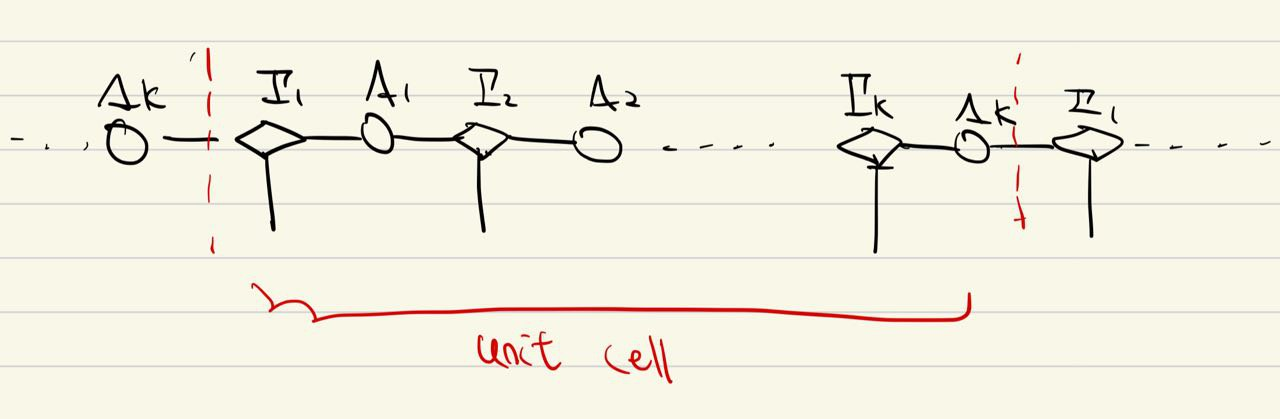

Then we can do a right grouping or the left grouping to get the left and right transfer matrix

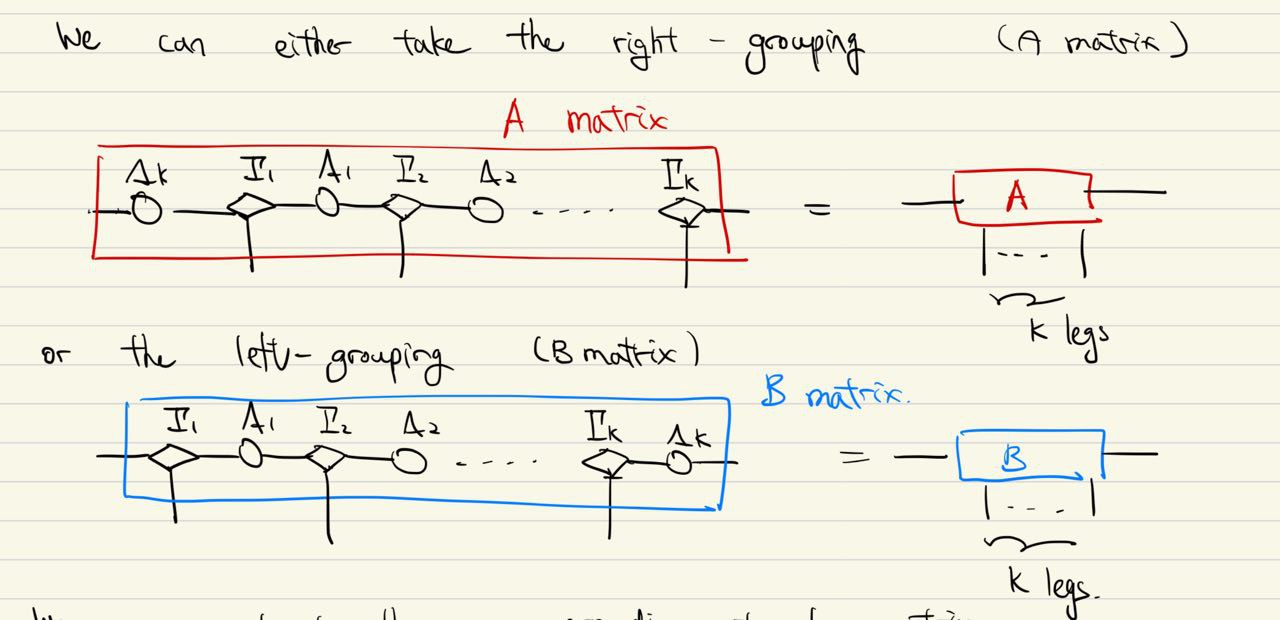

From the MPS normalization condition above, it is easy to see that the B matrix has a left and right eigenvector as follows

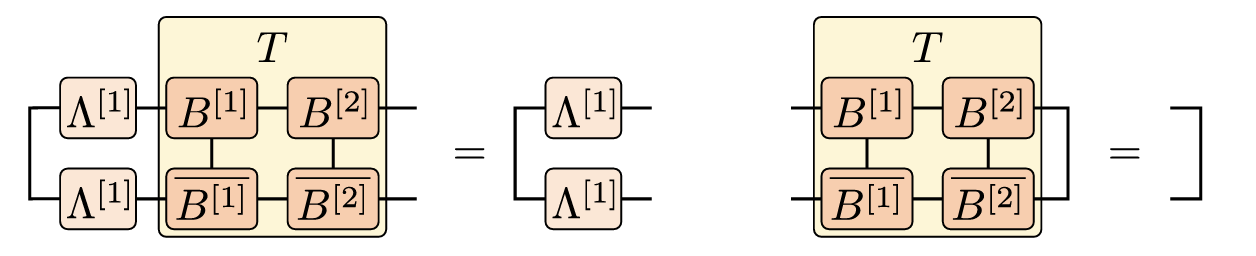

This is simply a rewritting of the normalization rule above.